In [101]:
import hashlib
import numpy as np
import csv
from Bio import SeqIO
import matplotlib.pyplot as plt
from Bio import Phylo
from io import StringIO
import pandas as pd
import time


### Step 1: Load genome sequences and extract k-mers
This step involves reading the genome sequences from FASTA files and extracting all possible 14-mers.

**Functions**:
- `load_fasta`: Loads the genome sequences from a FASTA file.
- `extract_kmers`: Extracts unique k-mers of a specified length from a sequence.

**Input**:
- Genome FASTA file.

**Output**:
- Concatenated genome sequence (string).
- Set of unique 14-mers.


In [15]:
def load_fasta(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    concatenated_sequence = "".join(sequences)
    return concatenated_sequence

def extract_kmers(sequence, k=14):
    return {sequence[i:i+k] for i in range(len(sequence) - k + 1)}

In [17]:
# Test Step 1
file_path = "R6.fa"  # Example file path
sequence = load_fasta(file_path)
print(f"Loaded sequence (first 100 bases): {sequence[:100]}")

kmers = extract_kmers(sequence, k=14)
print(f"Extracted {len(kmers)} unique 14-mers (sample): {list(kmers)[:5]}")

Loaded sequence (first 100 bases): TTGAAAGAAAAACAATTTTGGAATCGTATATTAGAATTTGCACAAGAAAGACTGACTCGATCCATGTATGATTTCTATGCTATTCAAGCTGAACTTATCA
Extracted 1952351 unique 14-mers (sample): ['TGTAGTACAAACTC', 'ATCTTTTCCAGACG', 'ATCTTTTGGATTTG', 'TAGAAACCCAATAG', 'TTCTATTATAGACG']



### Step 2: Generate MinHash sketches
This step generates MinHash sketches for each genome by hashing the k-mers and selecting the smallest hashes.

**Functions**:
- `hash_kmer`: Hashes a k-mer and its reverse complement to get the canonical hash.
- `minhash_sketch`: Creates a MinHash sketch of specified size and optionally saves it to a file.

**Input**:
- Set of k-mers.

**Output**:
- MinHash sketch (list of integers).
- Saved sketch file (optional).


In [28]:
def hash_kmer(kmer):
    reverse_comp = kmer[::-1].translate(str.maketrans("ACGT", "TGCA"))
    return min(int(hashlib.md5(kmer.encode()).hexdigest(), 16),
               int(hashlib.md5(reverse_comp.encode()).hexdigest(), 16))

def minhash_sketch(kmers, sketch_size=1000, genome_name=None, save_sketch=False):
    """
    Generate a MinHash sketch of a specified size and optionally save it to a file.

    Args:
        kmers (set of str): Set of k-mers to hash.
        sketch_size (int): Number of lowest hash values to include in the sketch.
        genome_name (str): Name of the genome (used for file naming).
        save_sketch (bool): If True, save the sketch to a file.

    Returns:
        list: MinHash sketch (list of lowest hash values).
    """
    hashes = {hash_kmer(kmer) for kmer in kmers}
    sketch = sorted(hashes)[:sketch_size]

    if save_sketch and genome_name:
        file_name = f"{genome_name}_sketch.txt"
        with open(file_name, "w") as f:
            for hash_value in sketch:
                f.write(f"{hash_value}\n")
        print(f"Sketch saved to {file_name}")

    return sketch

In [ ]:
# Test Step 2
sketch = minhash_sketch(kmers, sketch_size=1000, genome_name="R6", save_sketch=True)
print(f"Generated MinHash sketch (sample): {sketch[:5]}")


### Step 3: Calculate pairwise MinHash distances
This step calculates the Jaccard distance between the MinHash sketches of different genomes.

**Functions**:
- `minhash_distance`: Computes the Jaccard distance between two MinHash sketches.

**Input**:
- MinHash sketches of two genomes.

**Output**:
- Jaccard distance (float).


In [30]:
def minhash_distance(sketch_a, sketch_b):
    set_a, set_b = set(sketch_a), set(sketch_b)
    intersection = len(set_a & set_b)
    union = len(set_a | set_b)
    return 1 - (intersection / union)

In [36]:
# Test Step 3
sketch_a = minhash_sketch(kmers, sketch_size=1000)
sketch_b = minhash_sketch(kmers, sketch_size=1000)  # Reuse for testing
distance = minhash_distance(sketch_a, sketch_b)
print(f"Calculated MinHash distance: {distance}")

Calculated MinHash distance: 0.0



### Step 4: Construct the distance matrix
This step generates a pairwise distance matrix from the computed MinHash distances.

**Functions**:
- `construct_distance_matrix`: Builds the distance matrix and optionally saves it to a file.

**Input**:
- List of genome names.
- Pairwise MinHash distances.

**Output**:
- Symmetric distance matrix (numpy array).
- Saved distance matrix file.


In [126]:
def construct_distance_matrix(labels, distances, display_graphical=False, output_path="pairwise_distance_matrix.txt"):
    """
    Construct a square distance matrix from pairwise distances, optionally display it graphically,
    and save it to a text file.

    Args:
        labels (list of str): Names of the sequences.
        distances (dict): Pairwise distances as {(label_a, label_b): distance}.
        display_graphical (bool): If True, print the distance matrix as a table.
        output_path (str): Path to save the distance matrix as a text file.

    Returns:
        np.ndarray: Symmetric distance matrix.
    """
    size = len(labels)
    matrix = np.zeros((size, size))
    label_to_index = {label: idx for idx, label in enumerate(labels)}

    # Populate the matrix
    for (label_a, label_b), distance in distances.items():
        i, j = label_to_index[label_a], label_to_index[label_b]
        matrix[i, j] = distance
        matrix[j, i] = distance

    # Prepare the graphical output
    header = "\t" + "\t".join(labels)
    rows = [f"{labels[i]}\t" + "\t".join(f"{matrix[i, j]:.4f}" for j in range(size)) for i in range(size)]
    graphical_output = header + "\n" + "\n".join(rows)

    # Display the graphical representation
    if display_graphical:
        print("Distance Matrix (Graphical Representation):")
        print(graphical_output)

    # Save the distance matrix to a text file
    with open(output_path, "w") as f:
        f.write(graphical_output)
    print(f"Distance matrix saved to {output_path}")

    return matrix

In [48]:
# Test Step 4
genome_files = ["R6.fa", "TIGR4.fa"]  # Example genome files
distances = {("R6.fa", "TIGR4.fa"): 0.25}  # Example distance
matrix = construct_distance_matrix(genome_files, distances, display_graphical=True)
print("Distance matrix:", matrix)

Distance Matrix (Graphical Representation):
	R6.fa	TIGR4.fa
R6.fa	0.0000	0.2500
TIGR4.fa	0.2500	0.0000
Distance matrix saved to pairwise_distance_matrix.txt
Distance matrix: [[0.   0.25]
 [0.25 0.  ]]



### Step 5: Infer the phylogenetic tree
This step infers the phylogenetic tree using the Neighbor-Joining algorithm.

**Functions**:
- `doNeighbourJoining`: Infers the tree in Newick format from the distance matrix.
- `save_newick`: Saves the Newick tree to a file.
- `plot_tree_from_newick`: Plots the phylogenetic tree and saves it as an image.

**Input**:
- Distance matrix.
- Genome names.

**Output**:
- Newick tree string.
- Saved tree file.
- Saved tree plot.


To implement **neighbour-joining** I use functions from : https://github.com/sness/courses/blob/master/neighbour-joining.py

In [207]:
def calculateQ(d):
    r = d.shape[0]
    q = np.zeros((r, r))
    for i in range(r):
        for j in range(r):
            if i != j:
                sumI = np.sum(d[i, :])
                sumJ = np.sum(d[j, :])
                q[i, j] = (r - 2) * d[i, j] - sumI - sumJ
    return q

def findLowestPair(q):
    minVal = np.inf
    minIndex = (0, 0)
    for i in range(q.shape[0]):
        for j in range(i + 1, q.shape[0]):
            if q[i, j] < minVal:
                minVal = q[i, j]
                minIndex = (i, j)
    return minIndex

def calculateNewDistanceMatrix(f, g, d):
    r = d.shape[0]
    indices = [i for i in range(r) if i != f and i != g]
    new_d = np.zeros((r - 1, r - 1))
    for i, ii in enumerate(indices):
        for j, jj in enumerate(indices):
            new_d[i + 1, j + 1] = d[ii, jj]
    for i, ii in enumerate(indices):
        new_distance = (d[f, ii] + d[g, ii] - d[f, g]) / 2
        new_d[0, i + 1] = new_distance
        new_d[i + 1, 0] = new_distance
    new_d[0, 0] = 0
    return new_d

Then, I based on the Newick phylogeny format.

In [118]:
def doNeighbourJoining(d, labels):
    """
    Perform the Neighbor-Joining algorithm to build a phylogenetic tree.

    Args:
        d (np.ndarray): Distance matrix.
        labels (list): List of labels corresponding to rows/columns of the distance matrix.

    Returns:
        str: Newick-formatted string representing the tree.
    """
    while len(labels) > 2:
        # Step 1: Compute Q-matrix
        q = calculateQ(d)
        
        # Step 2: Find the pair with the smallest Q-value
        i, j = findLowestPair(q)
        
        # Step 3: Compute the distance to the new node
        r = d.shape[0]
        sumI = np.sum(d[i, :])
        sumJ = np.sum(d[j, :])
        distToNewNode = (d[i, j] + (sumI - sumJ) / (r - 2)) / 2
        
        # Step 4: Update labels
        new_label = f"({labels[i]}:{distToNewNode:.4f},{labels[j]}:{distToNewNode:.4f})"
        labels[i] = new_label
        labels.pop(j)
        
        # Step 5: Update distance matrix
        d = calculateNewDistanceMatrix(i, j, d)

    # Final step: Combine the last two labels
    tree = f"({labels[0]}:{d[0, 1]:.4f},{labels[1]}:{d[0, 1]:.4f});"
    return tree


def save_newick(tree, output_path="tree.nwk"):
    with open(output_path, "w") as f:
        f.write(tree)
    print(f"Newick tree saved to {output_path}")

def plot_tree_from_newick(newick_path, output_path="tree.png"):
    with open(newick_path, "r") as f:
        tree = Phylo.read(f, "newick")
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    Phylo.draw(tree, axes=ax, do_show=False)
    plt.savefig(output_path)
    print(f"Tree plotted and saved as {output_path}")
    plt.close(fig)

Generated tree (Newick format): (14412_3#82.contigs_velvet.fa:0.2500,14412_3#84.contigs_velvet.fa:0.2500);
Newick tree saved to test_tree.nwk


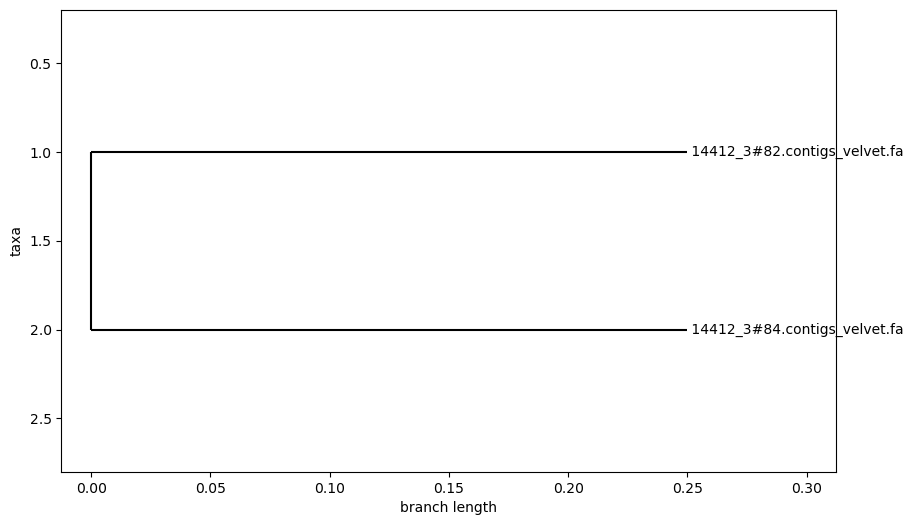

In [132]:
# Test Step 5
tree = doNeighbourJoining(matrix, genome_files)
print(f"Generated tree (Newick format): {tree}")

save_newick(tree, "test_tree.nwk")

# Plot the tree inline
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

with open("test_tree.nwk", "r") as f:
    phylo_tree = Phylo.read(f, "newick")

Phylo.draw(phylo_tree, axes=ax)
plt.show()

### Step 6: Compare full distances vs. MinHash distances
This step compares the Jaccard distances from the full k-mer set with the MinHash-based distances for accuracy and efficiency.

**Functions**:
- `minhash_distance`: Reused to calculate MinHash distances for different sketch sizes.
- `full_distance`: Calculate distances for different k-mers sizes.

**Input**:
- Full k-mer Jaccard distances.
- MinHash distances.

**Output**:
- Comparin:


In [134]:
def full_distance(kmers_a, kmers_b):
    """
    Calculate the full Jaccard distance between two sets of k-mers.

    Args:
        kmers_a (set): Set of k-mers from genome A.
        kmers_b (set): Set of k-mers from genome B.

    Returns:
        float: Jaccard distance between the two sets.
    """
    set_a, set_b = set(kmers_a), set(kmers_b)
    intersection = len(set_a & set_b)
    union = len(set_a | set_b)
    return 1 - (intersection / union)

def minhash_distance(sketch_a, sketch_b):
    set_a, set_b = set(sketch_a), set(sketch_b)
    intersection = len(set_a & set_b)
    union = len(set_a | set_b)
    return 1 - (intersection / union)

In [136]:
# Define the sequences and their k-mers
# Same as in the Challenge example: 
sequence_a_kmers = {
    "TTGAAAGAAAAACA", "TGAAAGAAAAACAA", "GAAAGAAAAACAAT", "AAAGAAAAACAATT",
    "AAGAAAAACAATTT", "AGAAAAACAATTTT", "GAAAAACAATTTTG"
}

sequence_b_kmers = {
    "TTGAAAGAAAAACA", "TGAAAGAAAAACAA", "GAAAGAAAAACAAT", "AAAGAAAAACAATT",
    "GAAAAACAATTTTG", "CTCGATCCATGTAT", "TCGATCCATGTATG"
}

# Calculate Full Jaccard Distance
full_jaccard_distance = full_distance(sequence_a_kmers, sequence_b_kmers)
print(f"Full Jaccard Distance: {full_jaccard_distance}")

# Generate MinHash sketches
sketch_a = minhash_sketch(sequence_a_kmers, sketch_size=5)
sketch_b = minhash_sketch(sequence_b_kmers, sketch_size=5)

# Calculate MinHash Jaccard Distance
minhash_jaccard_distance = minhash_distance(sketch_a, sketch_b)
print(f"MinHash Jaccard Distance (sketch size 5): {minhash_jaccard_distance}")

Full Jaccard Distance: 0.4444444444444444
MinHash Jaccard Distance (sketch size 5): 0.5714285714285714


### Step 7: Analyze the impact of sketch size on distances
This step evaluates how changing the sketch size impacts the MinHash-based distances.

**Functions**:
- `minhash_sketch`: Reused to create sketches with different sizes.
- `minhash_distance`: Used to calculate distances for each sketch size.

**Input**:
- Set of k-mers.
- Sketch sizes.

**Output**:
- Distance changes across sketch sizes.
- A plot showing the relationship between sketch size and MinHash distance stability.


In [139]:
def minhash_sketch(kmers, sketch_size=1000, genome_name=None, save_sketch=False):
    """
    Generate a MinHash sketch of a specified size and optionally save it to a file.

    Args:
        kmers (set of str): Set of k-mers to hash.
        sketch_size (int): Number of lowest hash values to include in the sketch.
        genome_name (str): Name of the genome (used for file naming).
        save_sketch (bool): If True, save the sketch to a file.

    Returns:
        list: MinHash sketch (list of lowest hash values).
    """
    hashes = {hash_kmer(kmer) for kmer in kmers}
    sketch = sorted(hashes)[:sketch_size]

    if save_sketch and genome_name:
        file_name = f"{genome_name}_sketch.txt"
        with open(file_name, "w") as f:
            for hash_value in sketch:
                f.write(f"{hash_value}\n")
        print(f"Sketch saved to {file_name}")

    return sketch


def minhash_distance(sketch_a, sketch_b):
    set_a, set_b = set(sketch_a), set(sketch_b)
    intersection = len(set_a & set_b)
    union = len(set_a | set_b)
    return 1 - (intersection / union)

Sketch size: 5, MinHash Jaccard Distance: 0.33333333333333337
Sketch size: 10, MinHash Jaccard Distance: 0.33333333333333337
Sketch size: 20, MinHash Jaccard Distance: 0.26086956521739135
Sketch size: 50, MinHash Jaccard Distance: 0.2142857142857143
Sketch size: 100, MinHash Jaccard Distance: 0.24561403508771928
Sketch size: 200, MinHash Jaccard Distance: 0.23788546255506604
Sketch size: 500, MinHash Jaccard Distance: 0.24561403508771928
Sketch size: 1000, MinHash Jaccard Distance: 0.26238053866203304
Sketch size: 2000, MinHash Jaccard Distance: 0.27288428324697755
Sketch size: 5000, MinHash Jaccard Distance: 0.2701954679121259


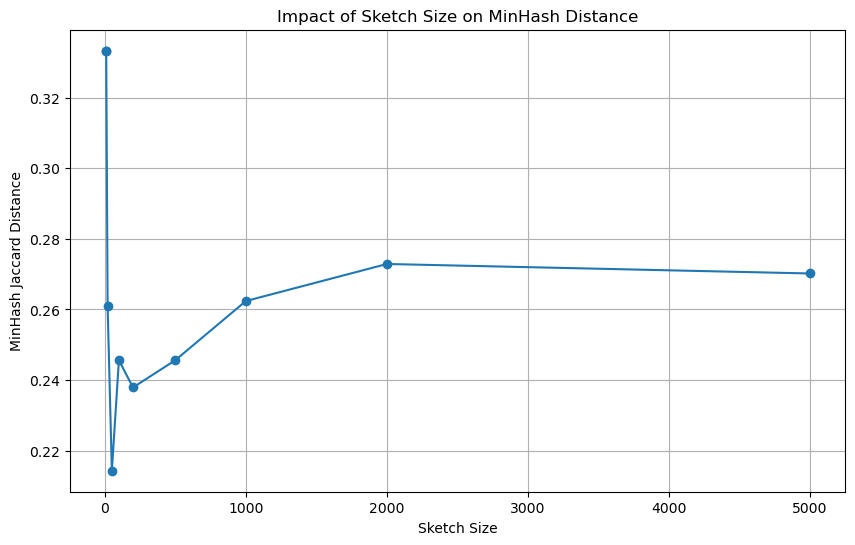

In [97]:
# Define genome files
genome_files = ["R6.fa", "TIGR4.fa"]

# Step 1: Load sequences and extract k-mers
sequences = {file: load_fasta(file) for file in genome_files}
kmers = {file: extract_kmers(seq, k=14) for file, seq in sequences.items()}

sequence_a_kmers = kmers["R6.fa"]
sequence_b_kmers = kmers["TIGR4.fa"]

# Step 2: Define sketch sizes to test
sketch_sizes = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

# Initialize results
results = []

# Step 3: Calculate MinHash distances for each sketch size
for sketch_size in sketch_sizes:
    sketch_a = minhash_sketch(sequence_a_kmers, sketch_size=sketch_size)
    sketch_b = minhash_sketch(sequence_b_kmers, sketch_size=sketch_size)
    distance = minhash_distance(sketch_a, sketch_b)
    results.append((sketch_size, distance))
    print(f"Sketch size: {sketch_size}, MinHash Jaccard Distance: {distance}")

# Step 4: Plot the impact of sketch size on distance
sketch_sizes, distances = zip(*results)
plt.figure(figsize=(10, 6))
plt.plot(sketch_sizes, distances, marker='o')
plt.title("Impact of Sketch Size on MinHash Distance")
plt.xlabel("Sketch Size")
plt.ylabel("MinHash Jaccard Distance")
plt.grid()
plt.show()

In [141]:
# Step 2: Define sketch sizes to test
sketch_sizes = [10, 50, 100, 250, 500, 1000, 2000, 3000, 4000, 5000]

# Initialize results
results = []

# Step 3: Calculate MinHash distances for each sketch size and record time
for sketch_size in sketch_sizes:
    start_time = time.time()  # Record the start time
    
    # Generate MinHash sketches and compute distance
    sketch_a = minhash_sketch(sequence_a_kmers, sketch_size=sketch_size)
    sketch_b = minhash_sketch(sequence_b_kmers, sketch_size=sketch_size)
    distance = minhash_distance(sketch_a, sketch_b)
    
    end_time = time.time()  # Record the end time
    
    # Compute elapsed time
    elapsed_time = end_time - start_time
    
    # Append results and print with timestamp
    results.append((sketch_size, distance, elapsed_time))
    print(f"Sketch size: {sketch_size}, MinHash Jaccard Distance: {distance}, Time Taken: {elapsed_time:.4f} seconds")

Sketch size: 10, MinHash Jaccard Distance: 0.4444444444444444, Time Taken: 0.0000 seconds
Sketch size: 50, MinHash Jaccard Distance: 0.4444444444444444, Time Taken: 0.0000 seconds
Sketch size: 100, MinHash Jaccard Distance: 0.4444444444444444, Time Taken: 0.0000 seconds
Sketch size: 250, MinHash Jaccard Distance: 0.4444444444444444, Time Taken: 0.0000 seconds
Sketch size: 500, MinHash Jaccard Distance: 0.4444444444444444, Time Taken: 0.0000 seconds
Sketch size: 1000, MinHash Jaccard Distance: 0.4444444444444444, Time Taken: 0.0000 seconds
Sketch size: 2000, MinHash Jaccard Distance: 0.4444444444444444, Time Taken: 0.0000 seconds
Sketch size: 3000, MinHash Jaccard Distance: 0.4444444444444444, Time Taken: 0.0000 seconds
Sketch size: 4000, MinHash Jaccard Distance: 0.4444444444444444, Time Taken: 0.0000 seconds
Sketch size: 5000, MinHash Jaccard Distance: 0.4444444444444444, Time Taken: 0.0000 seconds


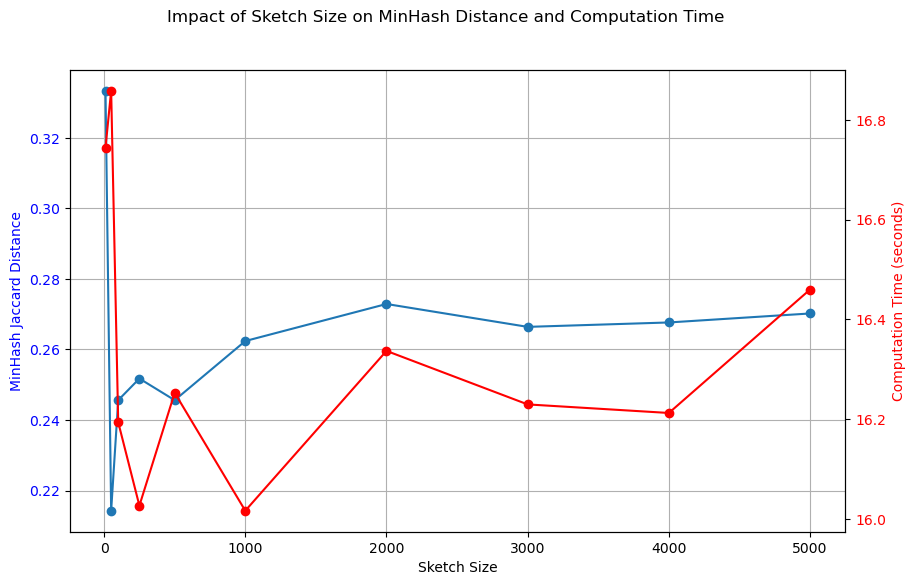

In [105]:
# Unpack results into sketch sizes, distances, and times
sketch_sizes, distances, times = zip(*results)

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MinHash Jaccard distances on the primary y-axis
ax1.plot(sketch_sizes, distances, marker='o', label='MinHash Jaccard Distance')
ax1.set_xlabel("Sketch Size")
ax1.set_ylabel("MinHash Jaccard Distance", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for computation time
ax2 = ax1.twinx()
ax2.plot(sketch_sizes, times, marker='o', color='red', label='Computation Time')
ax2.set_ylabel("Computation Time (seconds)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add grid and title
fig.suptitle("Impact of Sketch Size on MinHash Distance and Computation Time")
ax1.grid()

# Show the plot
plt.show()


### Step 8: Build neighbor-joining tree with different distances
This step builds neighbor-joining trees using different distance measures (full k-mer Jaccard distance and MinHash-based Jaccard distance).

**Functions**:
- `full_distance`: Calculates the Jaccard distance between full k-mer sets.
- `minhash_distance`: Approximates Jaccard distance using MinHash sketches.
- `doNeighbourJoining`: Builds neighbor-joining trees using the distance matrices.

**Input**:
- Genome k-mers and their MinHash sketches.
- Distance matrices from full k-mer and MinHash-based distances.

**Output**:
- Neighbor-joining trees for comparison.

**Inputs**

Genome files: ['R6.fa', 'TIGR4.fa', '14412_3#82.contigs_velvet.fa', '14412_3#84.contigs_velvet.fa']
Kmers keys: ['R6.fa', 'TIGR4.fa', '14412_3#82.contigs_velvet.fa', '14412_3#84.contigs_velvet.fa']

Method: Full Jaccard Distance
Calculating pairwise distances...
Distance matrix saved to pairwise_distance_matrix.txt
Time for Full Jaccard Distance Matrix: 3.5381 seconds
Full Jaccard Distance Matrix:
[[0.         0.97436876 0.98867522 0.98870067]
 [0.97436876 0.         0.98845316 0.98848052]
 [0.98867522 0.98845316 0.         0.56082534]
 [0.98870067 0.98848052 0.56082534 0.        ]]

Method: MinHash Jaccard Distance
Generating MinHash sketches...
Time for MinHash Sketches: 31.2722 seconds
Calculating pairwise distances...
Distance matrix saved to pairwise_distance_matrix.txt
Time for MinHash Distance Matrix: 0.0032 seconds
MinHash Jaccard Distance Matrix:
[[0.         0.26238054 0.98682877 0.98682877]
 [0.26238054 0.         0.98580122 0.98631526]
 [0.98682877 0.98580122 0.         0.2

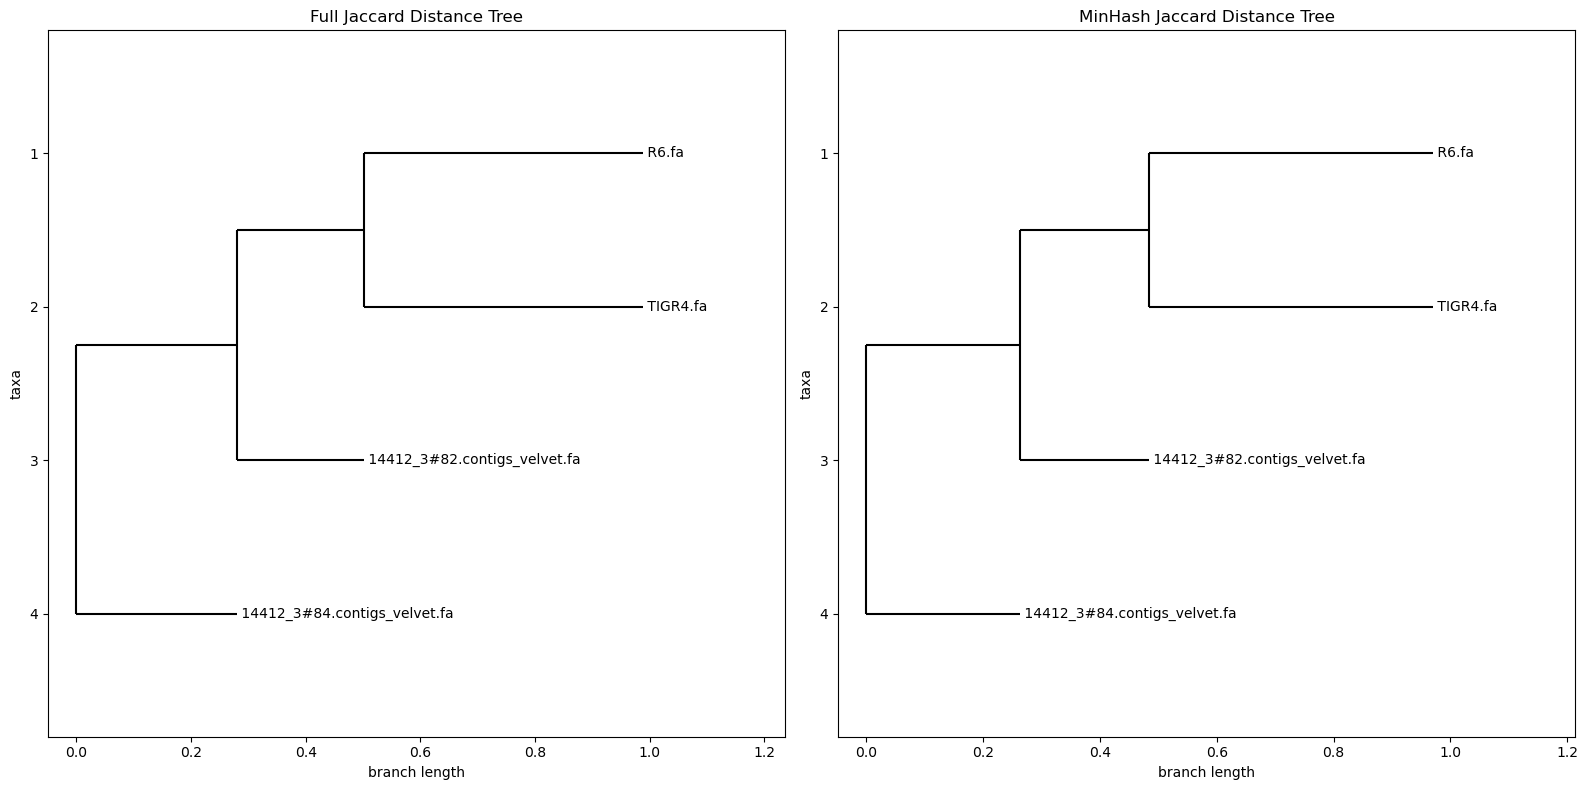

In [201]:
# Inputs: Genome k-mers and MinHash sketches
genome_files = ["R6.fa", "TIGR4.fa", "14412_3#82.contigs_velvet.fa", "14412_3#84.contigs_velvet.fa"]

# Load sequences and extract k-mers
sequences = {file: load_fasta(file) for file in genome_files}
kmers = {file: extract_kmers(sequences[file], k=14) for file in genome_files}

# Ensure consistency of keys
print("Genome files:", genome_files)
print("Kmers keys:", list(kmers.keys()))

# Step 1: Compute Full Jaccard Distance Matrix
print("\nMethod: Full Jaccard Distance")
print("Calculating pairwise distances...")
start_time = time.time()
full_distances = {
    (genome_files[i], genome_files[j]): full_distance(kmers[genome_files[i]], kmers[genome_files[j]])
    for i in range(len(genome_files)) for j in range(i + 1, len(genome_files))
}
full_distance_matrix = construct_distance_matrix(
    genome_files, full_distances, display_graphical=False
)
full_matrix_time = time.time() - start_time
print(f"Time for Full Jaccard Distance Matrix: {full_matrix_time:.4f} seconds")
print("Full Jaccard Distance Matrix:")
print(full_distance_matrix)

# Step 2: Generate MinHash Sketches and Compute MinHash Jaccard Distance Matrix
print("\nMethod: MinHash Jaccard Distance")
print("Generating MinHash sketches...")
start_time = time.time()
minhash_sketches = {
    file: minhash_sketch(kmers[file], sketch_size=1000) for file in genome_files
}
sketch_time = time.time() - start_time
print(f"Time for MinHash Sketches: {sketch_time:.4f} seconds")

print("Calculating pairwise distances...")
start_time = time.time()
minhash_distances = {
    (genome_files[i], genome_files[j]): minhash_distance(
        minhash_sketches[genome_files[i]], minhash_sketches[genome_files[j]]
    )
    for i in range(len(genome_files)) for j in range(i + 1, len(genome_files))
}
minhash_distance_matrix = construct_distance_matrix(
    genome_files, minhash_distances, display_graphical=False
)
minhash_matrix_time = time.time() - start_time
print(f"Time for MinHash Distance Matrix: {minhash_matrix_time:.4f} seconds")
print("MinHash Jaccard Distance Matrix:")
print(minhash_distance_matrix)

# Step 3: Generate Neighbor-Joining Trees
print("\nGenerating Neighbor-Joining Trees...")
start_time = time.time()
full_tree = doNeighbourJoining(full_distance_matrix, genome_files)
full_tree_time = time.time() - start_time
print(f"Time for Full Jaccard Tree: {full_tree_time:.4f} seconds")

start_time = time.time()
minhash_tree = doNeighbourJoining(minhash_distance_matrix, genome_files)
minhash_tree_time = time.time() - start_time
print(f"Time for MinHash Jaccard Tree: {minhash_tree_time:.4f} seconds")

# Step 4: Save and Plot Trees
save_newick(full_tree, "phylogenetic_full_tree.nwk")
save_newick(minhash_tree, "phylogenetic_minhash_tree.nwk")

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Full Jaccard Tree
ax1 = axes[0]
with open("phylogenetic_full_tree.nwk", "r") as f:
    full_phylo_tree = Phylo.read(f, "newick")
Phylo.draw(full_phylo_tree, do_show=False, axes=ax1)
ax1.set_title("Full Jaccard Distance Tree")

# MinHash Jaccard Tree
ax2 = axes[1]
with open("phylogenetic_minhash_tree.nwk", "r") as f:
    minhash_phylo_tree = Phylo.read(f, "newick")
Phylo.draw(minhash_phylo_tree, do_show=False, axes=ax2)
ax2.set_title("MinHash Jaccard Distance Tree")

# Adjust layout and display
plt.tight_layout()
plt.show()
